# Submission Nicolo Lüscher

In [269]:
# import libraries
from skimage import io, color, feature, transform, measure, exposure
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import dilation, square
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math
import itertools
import os
import tensorflow as tf
import time

train_again = False
use_model = "./model/model20231025-165803.h5"

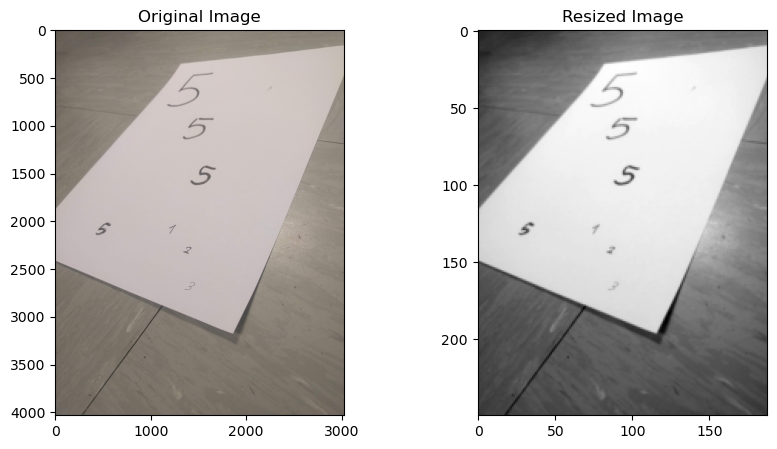

In [270]:
# load image
full_image = io.imread("./images/homework images vol 1/" + os.listdir("./images/homework images vol 1/")[6])
dest_size = 250

# resize image
reduced_image = transform.resize(full_image, (dest_size, dest_size*(full_image.shape[1]/full_image.shape[0])), anti_aliasing=True)
# convert to grayscale
gray_image = color.rgb2gray(reduced_image)


# plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(full_image)
ax[1].imshow(gray_image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Resized Image')
plt.show()


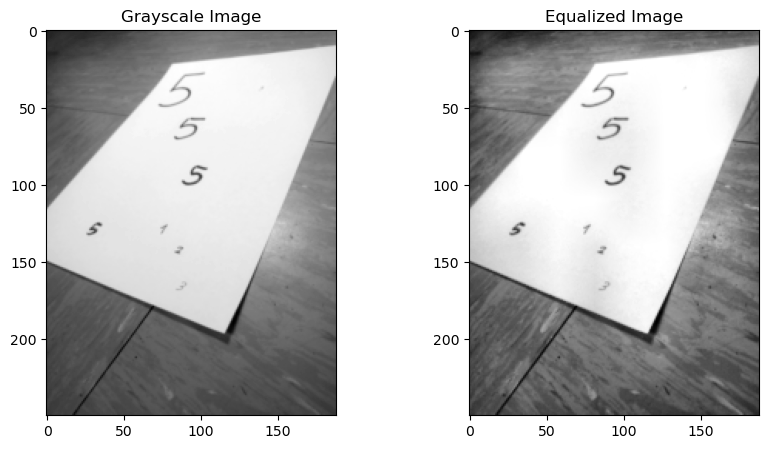

In [271]:
# even out the lighting on the page
equalized_image = exposure.equalize_adapthist(gray_image)

# plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Grayscale Image')
ax[1].imshow(equalized_image, cmap='gray')
ax[1].set_title('Equalized Image')
plt.show()


Text(0.5, 1.0, 'Binary Image')

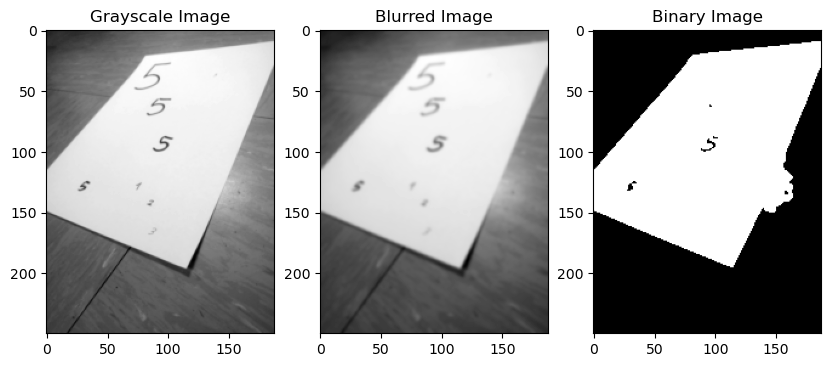

In [272]:

blurred_image = gaussian(gray_image, sigma=1)

# threshold image
thresh = threshold_otsu(blurred_image)
binary_image = blurred_image > thresh

# plotting
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(gray_image, cmap='gray')
ax[0].set_title('Grayscale Image')
ax[1].imshow(blurred_image, cmap='gray')
ax[1].set_title('Blurred Image')
ax[2].imshow(binary_image, cmap='gray')
ax[2].set_title('Binary Image')

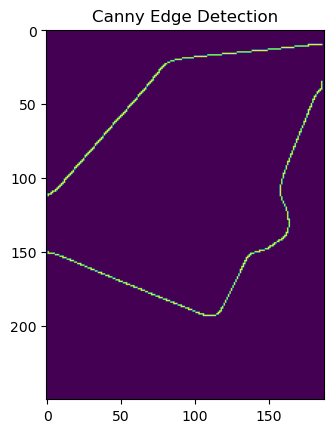

In [273]:
# dilate image
imedges = feature.canny(binary_image, sigma=5)

# plotting
plt.title('Canny Edge Detection')
plt.imshow(imedges)
plt.show()

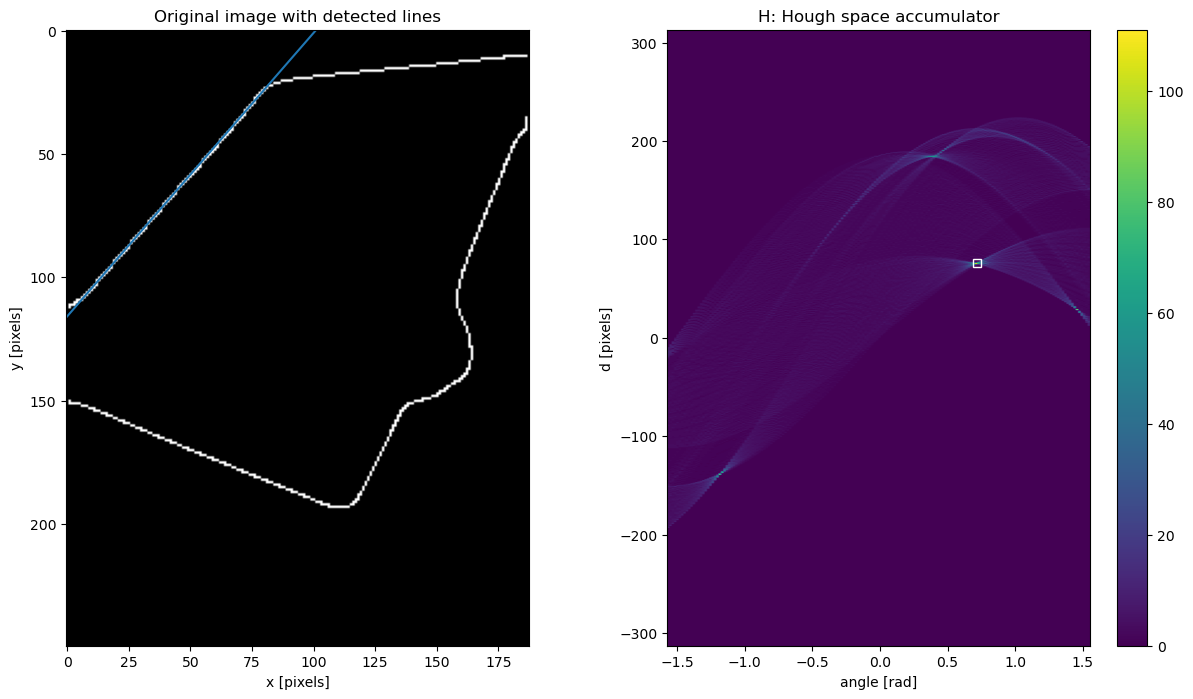

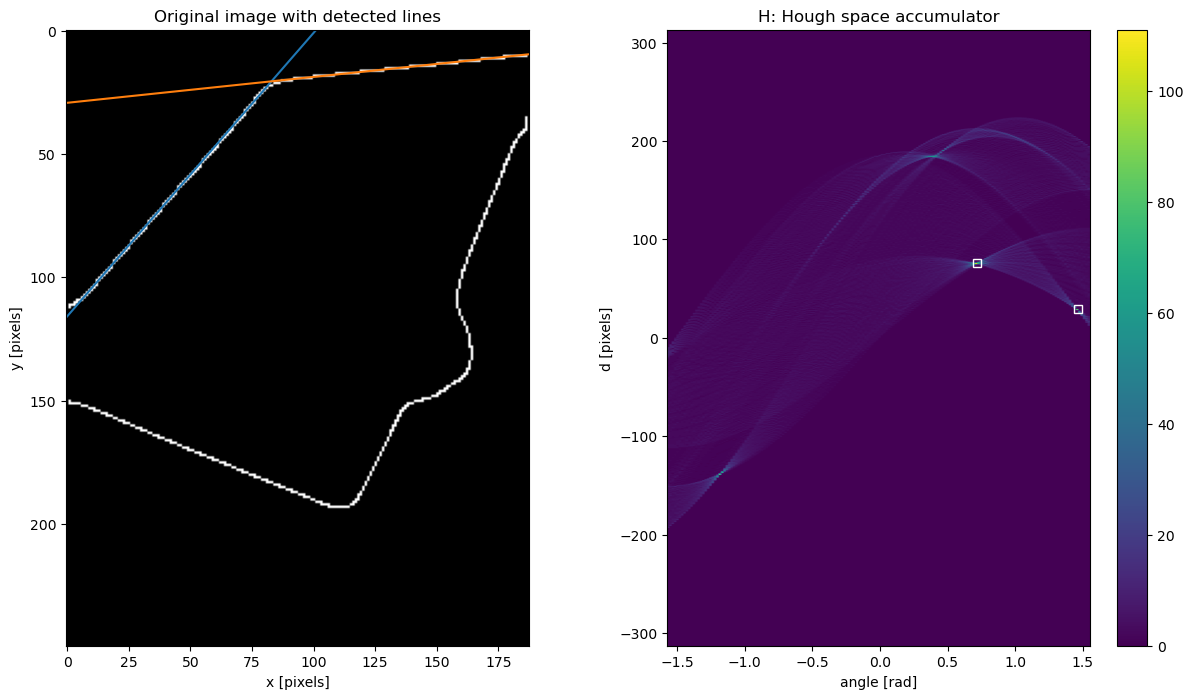

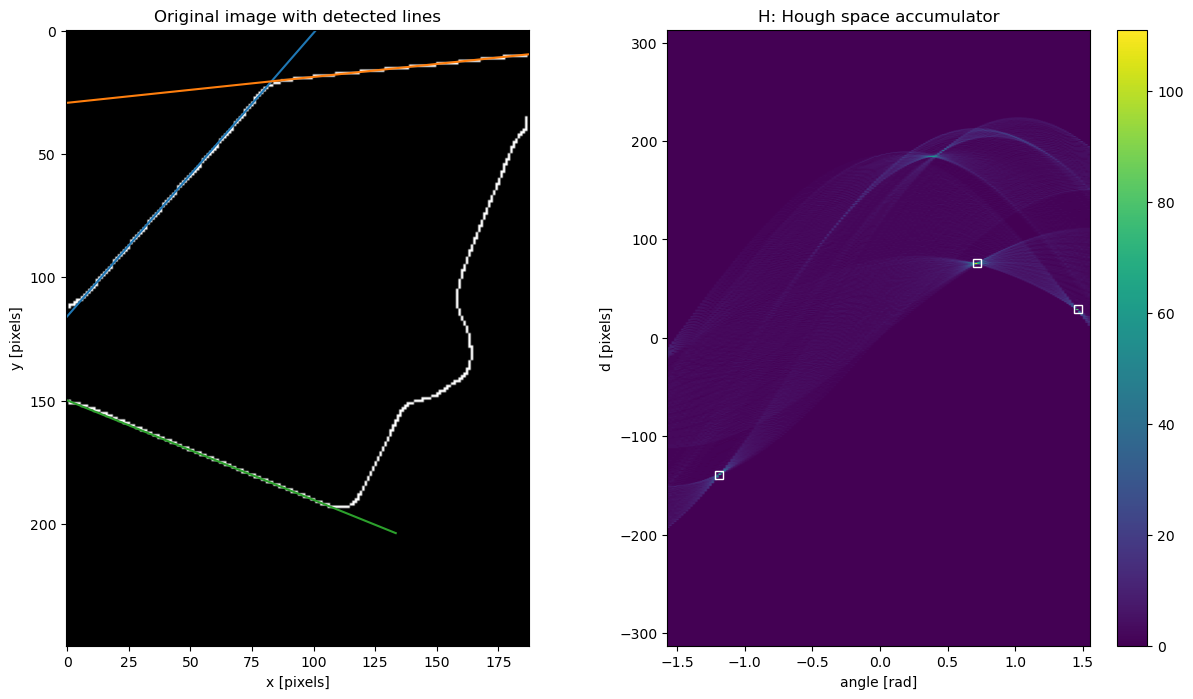

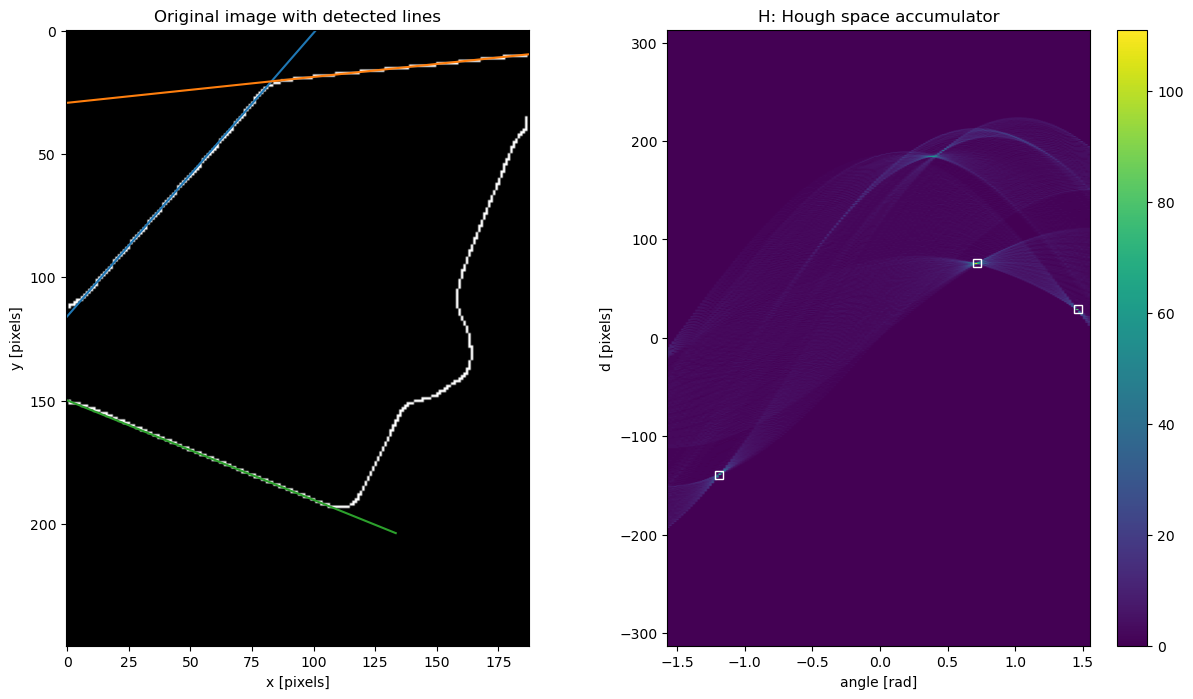

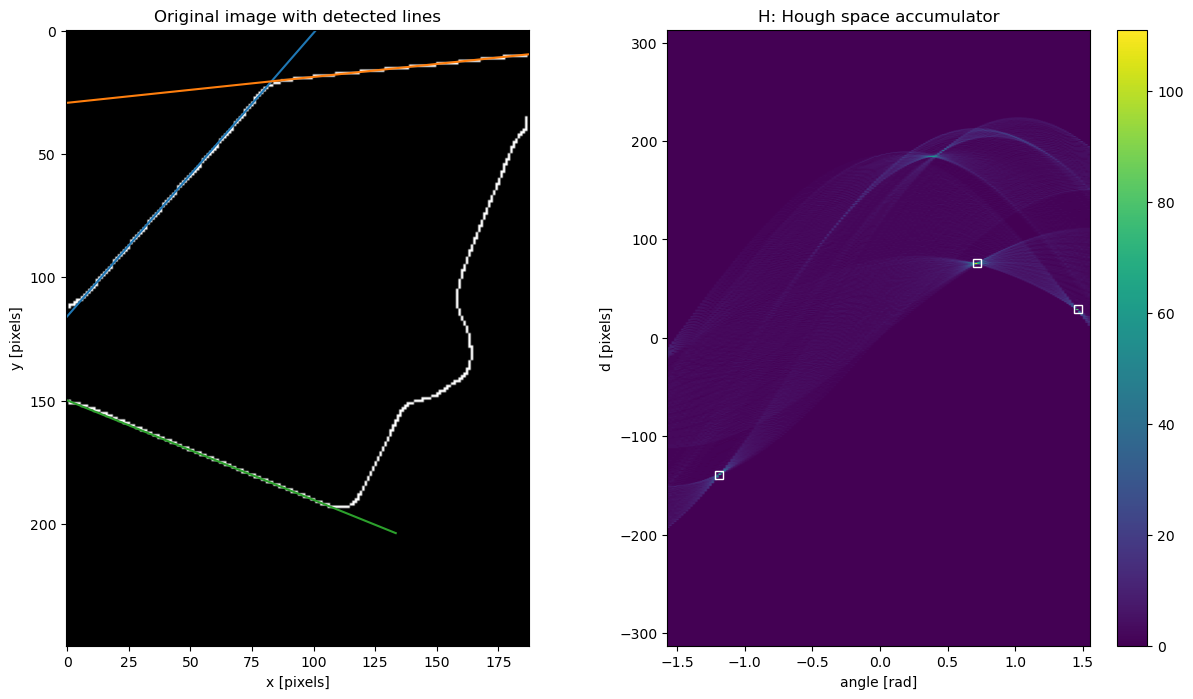

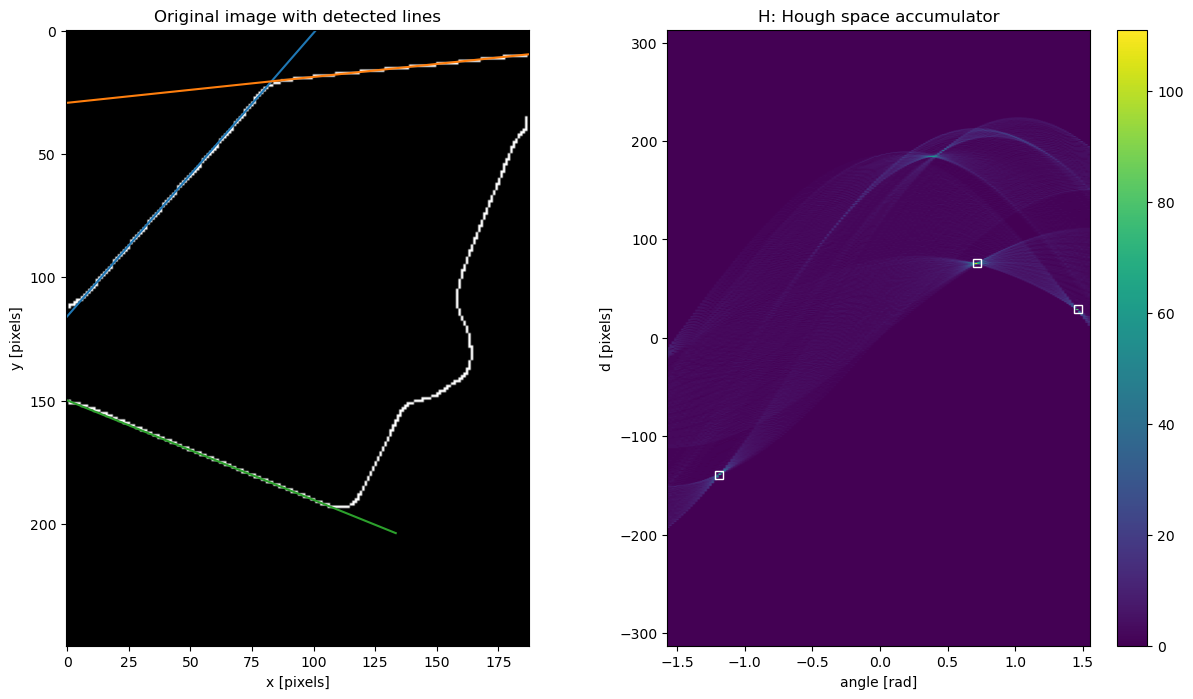

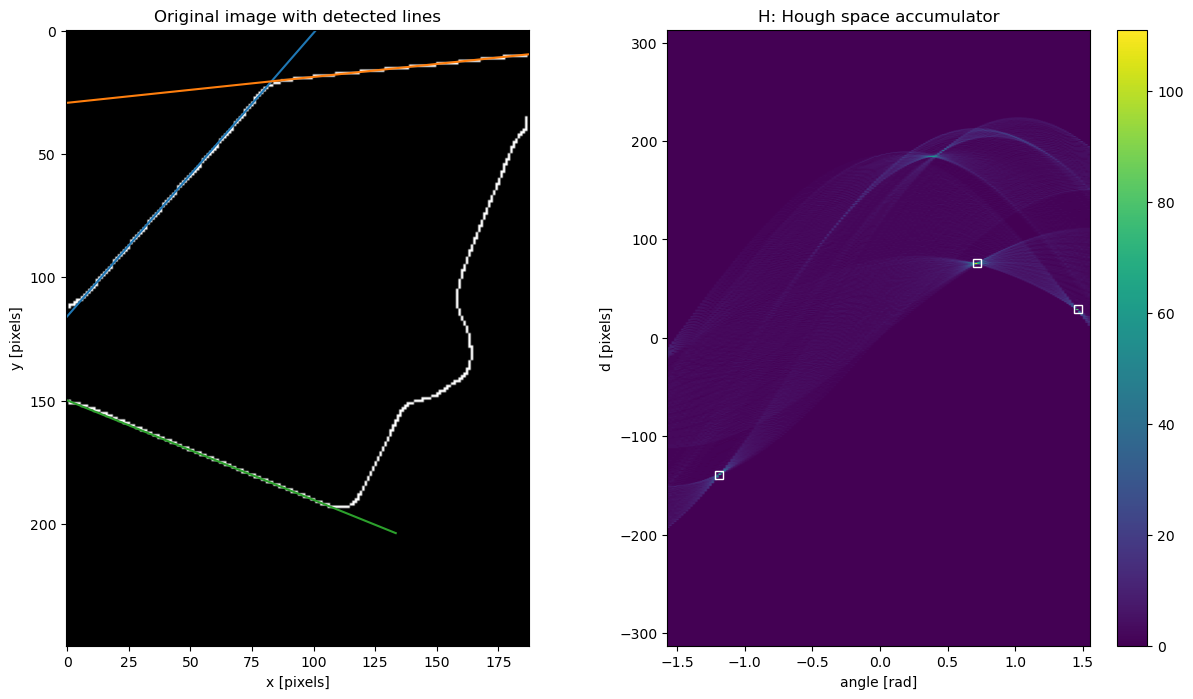

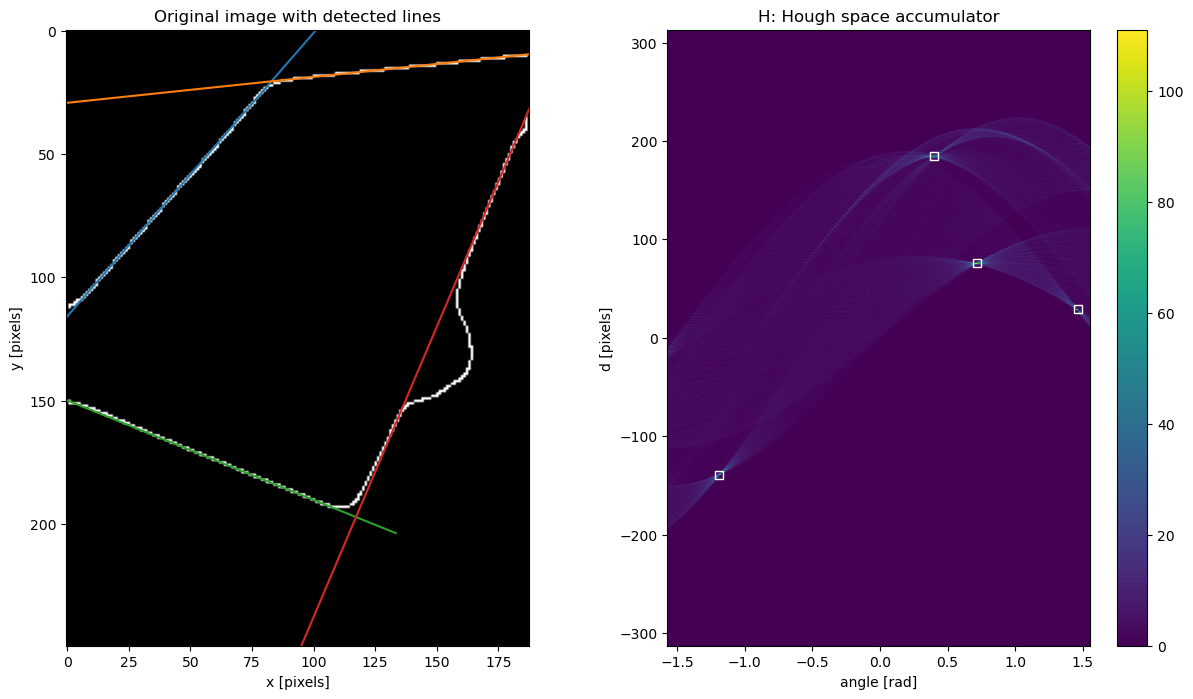

In [274]:
def find_corners(k, imedges):
    # perform Hough transform
    H, angles, distances = transform.hough_line(imedges)
    
    # find the indices of the top k highest values in H
    flattened_indices = np.argpartition(H.ravel(), -k)[-k:]
    indices_2D = np.unravel_index(flattened_indices, H.shape)

    # extract and sort the corresponding distances and angles
    distances_max = distances[indices_2D[0]]
    angles_max = angles[indices_2D[1]]
    sorted_indices = np.argsort(H[indices_2D])[::-1]
    distances_max = distances_max[sorted_indices]
    angles_max = angles_max[sorted_indices]

    # initialize lists to store accepted distances and angles
    accepted_distances = []
    accepted_angles = []

    # set thresholds for filtering lines
    distance_threshold = 50  # pixels
    angle_threshold = 0.4  # radians

    # plotting
    fig, (ax0, ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))
    ax0.set(xlabel="x [pixels]", ylabel="y [pixels]", title="Original image with detected lines")
    ax0.imshow(imedges, cmap="gray")
    Himage = ax1.imshow(H, extent=(angles[0], angles[-1], distances[0], distances[-1]), origin="lower", aspect="auto")
    ax1.set(xlabel="angle [rad]", ylabel="d [pixels]", title="H: Hough space accumulator")
    plt.colorbar(Himage)

    # loop through the sorted highest values and filter lines
    for i in range(k):
        d = distances_max[i]
        theta = angles_max[i]
    
        # check if the line is too close or parallel to already accepted lines
        if len(accepted_distances) > 0:
            distances_diff = np.abs(np.abs(d) - np.abs(np.array(accepted_distances)))
            angles_diff = [np.arccos(np.cos(theta - accepted_theta)) for accepted_theta in accepted_angles]
            if any((distances_diff < distance_threshold) & ((np.array(angles_diff) < angle_threshold) | (np.array(angles_diff) > np.pi - angle_threshold))):
                continue
    
        # add the line to the list of accepted lines
        accepted_distances.append(d)
        accepted_angles.append(theta)
    
        # plot a white rectangle over the maximum in Hough space
        ax1.plot(theta, d, "ws", fillstyle="none")
    
        # draw the line in image space
        p1 = np.array([d * np.cos(theta), d * np.sin(theta)])
        linedir = np.array([np.cos(theta + np.pi / 2), np.sin(theta + np.pi / 2)])
        p0 = p1 - linedir * 200
        p2 = p1 + linedir * 200
        ax0.plot([p0[0], p2[0]], [p0[1], p2[1]], scalex=False, scaley=False)

    # initialize list to store intersection points
    intersections = []

    # loop through all pairs of lines to find intersections
    for i in range(len(accepted_distances)):
        for j in range(i + 1, len(accepted_distances)):
            d1, theta1 = accepted_distances[i], accepted_angles[i]
            d2, theta2 = accepted_distances[j], accepted_angles[j]
        
            # direction vectors
            dir1 = np.array([np.cos(theta1 + np.pi / 2), np.sin(theta1 + np.pi / 2)])
            dir2 = np.array([np.cos(theta2 + np.pi / 2), np.sin(theta2 + np.pi / 2)])
        
            # points on the lines
            p1 = np.array([d1 * np.cos(theta1), d1 * np.sin(theta1)])
            p2 = np.array([d2 * np.cos(theta2), d2 * np.sin(theta2)])
        
            # Solve for intersection
            A = np.vstack([dir1, -dir2]).T
            b = p2 - p1
            if np.linalg.matrix_rank(A) == 2:  # lines are not parallel
                t, s = np.linalg.solve(A, b)
                intersection = p1 + t * dir1
                intersections.append(intersection)

    # get the dimensions of the image
    height, width = imedges.shape

    def distance(p1, p2):
        return math.dist(p1, p2)

    def inside_image_percentage(points, width, height):
        x_coords, y_coords = zip(*points)
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)
    
        # Calculate the area of the bounding box inside the image
        x_min_clamped = max(0, x_min)
        x_max_clamped = min(width, x_max)
        y_min_clamped = max(0, y_min)
        y_max_clamped = min(height, y_max)
    
        if x_min_clamped < x_max_clamped and y_min_clamped < y_max_clamped:
            inside_area = (x_max_clamped - x_min_clamped) * (y_max_clamped - y_min_clamped)
            total_area = (x_max - x_min) * (y_max - y_min)
            return inside_area / total_area
        return 0

    def best_trapezoid_or_square(intersections, width, height):
        best_score = float('inf')
        best_combination = None
        
        for combination in itertools.combinations(intersections, 4):
            # Check if the bounding box of the combination is mostly inside the image
            if inside_image_percentage(combination, width, height) < 0.8:  # 80% threshold
                continue
            
            distances = sorted([distance(combination[i], combination[j]) for i in range(3) for j in range(i+1, 4)])
            
            # Score based on how square/trapezoid-like the combination is
            score = abs(distances[0] - distances[1]) + abs(distances[0] - distances[2]) + abs(distances[0] - distances[3]) + abs(distances[4] - distances[5])
            
            if score < best_score:
                best_score = score
                best_combination = combination

        if best_combination is None:
            return []
        return list(best_combination)


    intersections = best_trapezoid_or_square(np.array(intersections), width, height)

    return intersections

# Initial value for k
k = 1

# Loop until 4 corners are found
while True:
    intersections = find_corners(k, imedges)
    if len(intersections) == 4:
        break
    k += 1


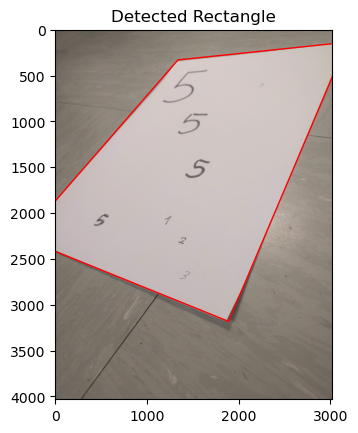

In [275]:
# create figure and axes
fig, ax = plt.subplots(1)

# rescale points to match the original image
intersections = np.array(intersections) * (full_image.shape[0] / dest_size)

# display the image
ax.imshow(full_image)

# calculate the centroid
centroid = np.mean(intersections, axis=0)

# sort the points based on the angle with the centroid
sorted_points = sorted(intersections, key=lambda point: -np.arctan2(point[1] - centroid[1], point[0] - centroid[0]))

# create a rectangle patch
rect = patches.Polygon(sorted_points, closed=True, edgecolor='r', facecolor='none')

# add the patch to the axes
ax.add_patch(rect)

# plotting
ax.set_title('Detected Rectangle')
plt.show()

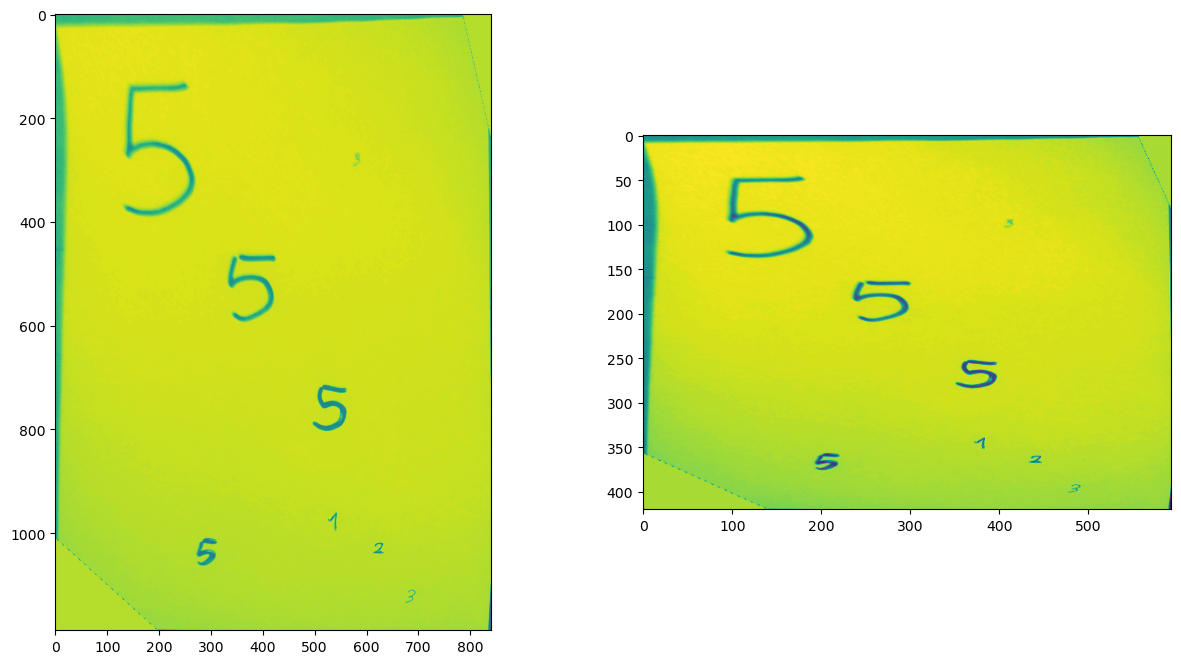

In [276]:
a, b, c, d = sorted_points[:4]
# size of the output image (A4 paper size)
w,h = 210 * 4, 297 * 4
A = np.array([0,h])
B = np.array([w,h])
C = np.array([w,0])
D = np.array([0,0])
invtf = transform.estimate_transform(
    "projective", src=np.vstack((A, B, C, D)), dst=np.vstack((a, b, c, d))
)

# wrap the image
warped = transform.warp(full_image, inverse_map=invtf, output_shape=(h, w))

# set the background to the average color of the image
warped[warped.sum(axis=2) == 0] = warped.mean(axis=(0, 1))

warped = color.rgb2gray(warped)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
ax1.imshow(warped)
ax2.imshow(transform.resize(warped, (210*2, 297*2)))
plt.show()

In [277]:
# get the height and width of the image
height, width = warped.shape

# calculate the aspect ratio
aspect_ratio = width / height

# check if the aspect ratio is greater than 1
if aspect_ratio > 1:
    print('The image is more likely to be landscape')
    wrapped = transform.resize(warped, (210*2, 297*2))
else:
    print('The image is more likely to be portrait')


The image is more likely to be portrait


Text(0.5, 1.0, 'Dilated Image')

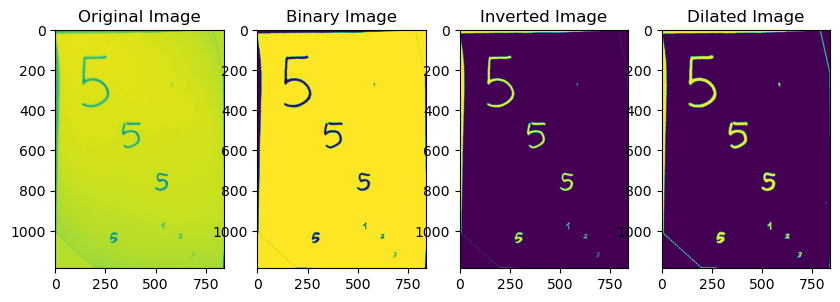

In [278]:
# boost contrast
alpha = 0.95
boosted_contrast = alpha * warped + (1 - alpha) * exposure.equalize_hist(warped)

# binarize image
thresh = threshold_otsu(boosted_contrast)
binary_image = boosted_contrast > thresh

# invert image
gray_image = 1 - binary_image

# dilate image
dilated_image = dilation(gray_image, square(4))

# plotting
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(warped)
ax[0].set_title('Original Image')
ax[1].imshow(binary_image)
ax[1].set_title('Binary Image')
ax[2].imshow(gray_image)
ax[2].set_title('Inverted Image')
ax[3].imshow(dilated_image)
ax[3].set_title('Dilated Image')

Text(0.5, 1.0, 'Labeled Image')

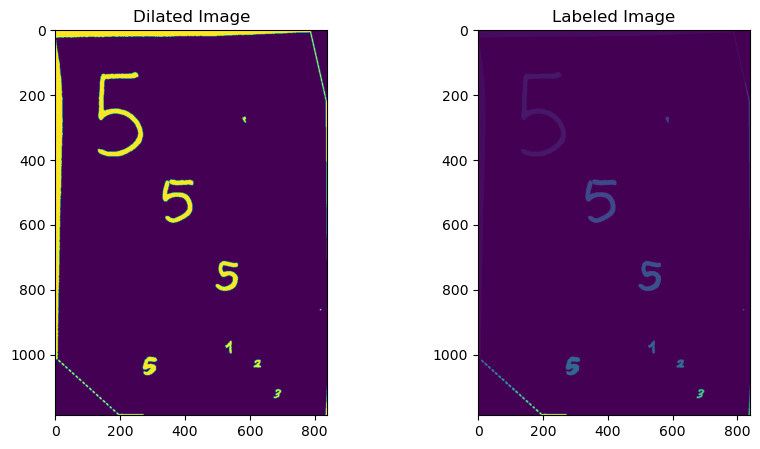

In [279]:
# perform connected component analysis
labeled_image = measure.label(dilated_image)

# plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dilated_image)
ax[0].set_title('Dilated Image')
ax[1].imshow(labeled_image)
ax[1].set_title('Labeled Image')


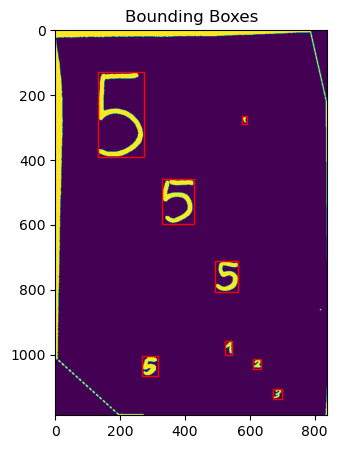

In [280]:
# loop through all connected components
bounding_boxes = []
for region in measure.regionprops(labeled_image):
        
        # skip too small and too large regions
        if region.area < 60 or region.area > 10000:
            continue
        
        # extract the bounding box coordinates
        minr, minc, maxr, maxc = region.bbox
        
        # skip images that are not roughly square
        if (maxr - minr) / (maxc - minc) > 4 or (maxc - minc) / (maxr - minr) > 4:
            continue

        # check if the bounding box is too close to the edge of the image
        if minr < 20 or minc < 20 or maxr > dilated_image.shape[0] - 20 or maxc > dilated_image.shape[1] - 20:
            continue
        
        # add the bounding box coordinates to the list with a 2 pixel margin
        bounding_boxes.append((minr - 2, minc - 2, maxr + 2, maxc + 2))

# plotting
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.imshow(dilated_image)

# loop through the bounding boxes and draw them on the image
for minr, minc, maxr, maxc in bounding_boxes:
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title('Bounding Boxes')
plt.show()

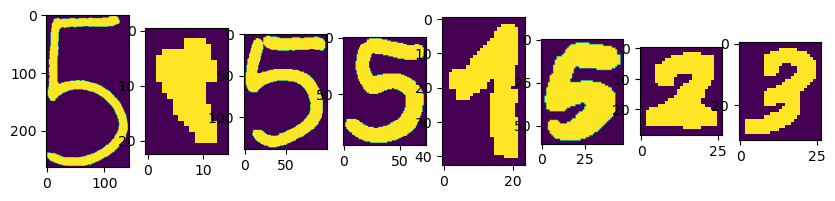

In [281]:
accepted_bounding_boxes = []

# loop through the bounding boxes

for minr, minc, maxr, maxc in bounding_boxes:
        
        # check if the bounding box is too close to an already accepted bounding box
        if len(accepted_bounding_boxes) > 0:
            distances = np.array([np.abs(minr - accepted_minr) for accepted_minr, _, _, _ in accepted_bounding_boxes])
            if any(distances < 10):
                continue
        
        # add the bounding box to the list of accepted bounding boxes
        accepted_bounding_boxes.append((minr, minc, maxr, maxc))

# plotting
fig, ax = plt.subplots(1, len(bounding_boxes), figsize=(10, 5))
for i, (minr, minc, maxr, maxc) in enumerate(bounding_boxes):
    ax[i].imshow(dilated_image[minr:maxr, minc:maxc])
plt.show()

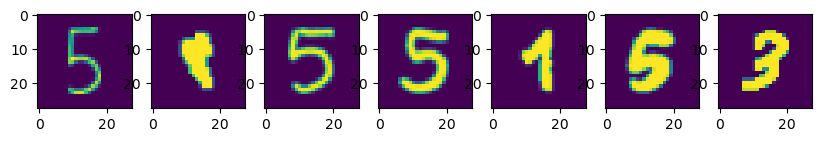

In [282]:
# resize the detected digits to 28x28 while keeping the aspect ratio, centering the digit and remove empty space around it
resized_digits = []
for minr, minc, maxr, maxc in accepted_bounding_boxes:
    digit = dilated_image[minr:maxr, minc:maxc]
    digit = transform.resize(digit, (20, int(20 * (maxc - minc) / (maxr - minr))))
    digit = np.pad(digit, ((4, 4), (4, 4)), 'constant', constant_values=0)

    
    # Calculate padding values ensuring they are non-negative
    left_pad = max(0, int((28 - digit.shape[1]) / 2))
    right_pad = max(0, 28 - digit.shape[1] - left_pad)
    
    digit = np.pad(digit, ((0, 0), (left_pad, right_pad)), 'constant', constant_values=0)
    
    # make sure the image is 28x28
    digit = transform.resize(digit, (28, 28))

    resized_digits.append(digit)

# plotting
fig, ax = plt.subplots(1, len(resized_digits), figsize=(10, 5))
for i, digit in enumerate(resized_digits):
    ax[i].imshow(digit)
plt.show()


In [283]:
def loadImages(path):
    with open(
        path,
        "rb",
    ) as f:
        bytes = f.read()
        magic_number = int.from_bytes(bytes[0:4], byteorder="big")
        number_of_items = int.from_bytes(bytes[4:8], byteorder="big")
        number_of_rows = int.from_bytes(bytes[8:12], byteorder="big")
        number_of_columns = int.from_bytes(bytes[12:16], byteorder="big")
        images = []
        for i in range(number_of_items):
            image = bytes[
                16
                + (i * number_of_rows * number_of_columns) : 16
                + (i * number_of_rows * number_of_columns)
                + number_of_rows * number_of_columns
            ]
            images += [image]
        assert magic_number == 2051
        assert number_of_items == len(images)
        return images
    
def loadLabels(path):
    with open(path, "rb") as f:
        bytes = f.read()
        labels = []
        magic_number = int.from_bytes(bytes[0:4], byteorder="big")
        number_of_items = int.from_bytes(bytes[4:8], byteorder="big")
        for i in range(8, number_of_items + 8):
            label = bytes[i]
            labels.append(label)
        assert magic_number == 2049
        assert number_of_items == len(labels)
        return labels
    
images_test = loadImages("./data/t10k-images-idx3-ubyte")
labels_test = loadLabels("./data/t10k-labels-idx1-ubyte")

if train_again:
    # load images for training
    images_training = loadImages("./data/train-images-idx3-ubyte")
    labels_training = loadLabels("./data/train-labels-idx1-ubyte")

    # prepare data
    print("len(images_training[0])", len(images_training[0]))
    X_train = np.array([np.frombuffer(image, dtype=np.uint8) for image in images_training])
    X_test = np.array([np.frombuffer(image, dtype=np.uint8) for image in images_test])
    y_train = tf.keras.utils.to_categorical(labels_training, num_classes=10)
    y_test = tf.keras.utils.to_categorical(labels_test, num_classes=10)

    # Define the model
    model = tf.keras.models.Sequential([
        # Input layer
        tf.keras.layers.InputLayer(input_shape=(784,)),
        
        # First dense layer with normalization and dropout
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        # Second dense layer with normalization and dropout
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        # Output layer
        tf.keras.layers.Dense(10, activation='softmax'),
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    # Display the model summary
    model.summary()


    model.fit(
        X_train,
        y_train,
        epochs=10
    )

    loss, accuracy = model.evaluate(X_test, y_test)
    print("Accuracy", accuracy)

    # save the model
    model.save('./model/model' + time.strftime("%Y%m%d-%H%M%S") + '.h5')
else:
    model = tf.keras.models.load_model(use_model)
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Accuracy", accuracy)


313/313 [==============================] - 3s 9ms/step - loss: 0.0957 - accuracy: 0.9705
Accuracy 0.9704999923706055


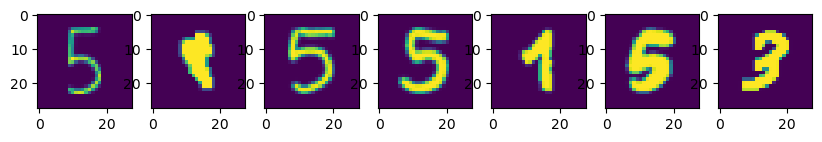

In [284]:
# convert the digit so the highest value is 255 and the lowest is 0 rounded to the nearest integer
resized_digits = np.array(resized_digits)
resized_digits = (resized_digits - resized_digits.min()) / (resized_digits.max() - resized_digits.min()) * 255
resized_digits = np.round(resized_digits).astype(np.uint8)

# plot the digits
fig, ax = plt.subplots(1, len(resized_digits), figsize=(10, 5))
for i, digit in enumerate(resized_digits):
    ax[i].imshow(digit)
plt.show()

1/1 [==============================] - 0s 68ms/step


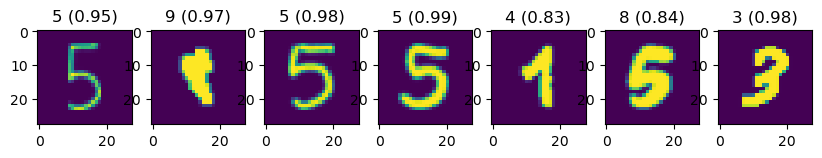

In [285]:
# predict the digits
predictions = model.predict(resized_digits.reshape(-1, 784))

# get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# plot the digits vertically with the predicted labels an the confidence, leaving enough space for the label
fig, ax = plt.subplots(1, len(resized_digits), figsize=(10, 5))
for i, digit in enumerate(resized_digits):
    ax[i].imshow(digit)
    ax[i].set_title(f"{predicted_labels[i]} ({predictions[i][predicted_labels[i]]:.2f})")
plt.show()